![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 13 - Attention and Transformers </center>
### <center> Transformers </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers/MainAttention.ipynb)

In [98]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [78]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn            as nn
import torch.optim         as optim
import torch.nn.functional as F
import torchinfo
import torchtext

from torchtext.vocab import Vocab

In [80]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/13_AttentionAndTransfomers/DeepLearningFramework ./DeepLearningFramework

### Transformer
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers//Transformer.png?raw=true" alt="Transformer" width=800>

#### Transformer = Encode + Decoder

In [95]:
dEmbbeding    = 256
nHead         = 8
nEncoderLayer = 3
nDecoderLayer = 4
dNN           = 512

oTransformer  = nn.Transformer(dEmbbeding, nHead, nEncoderLayer, nDecoderLayer, dNN)
torchinfo.summary(oTransformer)

Layer (type:depth-idx)                                            Param #
Transformer                                                       --
├─TransformerEncoder: 1-1                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          527,104
│    │    └─TransformerEncoderLayer: 3-2                          527,104
│    │    └─TransformerEncoderLayer: 3-3                          527,104
│    └─LayerNorm: 2-2                                             512
├─TransformerDecoder: 1-2                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerDecoderLayer: 3-4                          790,784
│    │    └─TransformerDecoderLayer: 3-5                          790,784
│    │    └─TransformerDecoderLayer: 3-6                          790,784
│    │    └─TransformerDecoderLayer: 3-7                          7

#### Encoder = [EncoderLayer] * `nEncoderLayer`

In [96]:
torchinfo.summary(oTransformer.encoder)

Layer (type:depth-idx)                                       Param #
TransformerEncoder                                           --
├─ModuleList: 1-1                                            --
│    └─TransformerEncoderLayer: 2-1                          --
│    │    └─MultiheadAttention: 3-1                          263,168
│    │    └─Linear: 3-2                                      131,584
│    │    └─Dropout: 3-3                                     --
│    │    └─Linear: 3-4                                      131,328
│    │    └─LayerNorm: 3-5                                   512
│    │    └─LayerNorm: 3-6                                   512
│    │    └─Dropout: 3-7                                     --
│    │    └─Dropout: 3-8                                     --
│    └─TransformerEncoderLayer: 2-2                          --
│    │    └─MultiheadAttention: 3-9                          263,168
│    │    └─Linear: 3-10                                     131,584
│    │  

##### Decoder = [DecoderLayer] * `nDecoderLayer`

In [97]:
torchinfo.summary(oTransformer.decoder)

Layer (type:depth-idx)                                       Param #
TransformerDecoder                                           --
├─ModuleList: 1-1                                            --
│    └─TransformerDecoderLayer: 2-1                          --
│    │    └─MultiheadAttention: 3-1                          263,168
│    │    └─MultiheadAttention: 3-2                          263,168
│    │    └─Linear: 3-3                                      131,584
│    │    └─Dropout: 3-4                                     --
│    │    └─Linear: 3-5                                      131,328
│    │    └─LayerNorm: 3-6                                   512
│    │    └─LayerNorm: 3-7                                   512
│    │    └─LayerNorm: 3-8                                   512
│    │    └─Dropout: 3-9                                     --
│    │    └─Dropout: 3-10                                    --
│    │    └─Dropout: 3-11                                    --
│    └─Trans

#### Load the data:

In [10]:
import re

def NormalizeEnglish(line):
    line = line.lower().strip()
    line = re.sub(r"([.!?])", r" \1",     line) #-- add space before [.!?]
    line = re.sub(r"[^a-zA-Z.!?]+", r" ", line) #-- keep only letters and [.!?]
    return line

def NormalizeHebrew(line):
    line = line.strip()
    line = re.sub(r"([.!?])", r" \1",            line)
    line = re.sub(r"[^\u0590-\u05fe.!?]+", r" ", line)
    return line

dirPath = '../../data/Translation//'
lLines  = []
with open(dirPath + 'heb.txt', encoding='utf-8') as oFile:
    for line in oFile:
        lSplit  = line.split('\t')[:2]
        lLines += [(NormalizeEnglish(lSplit[0]), NormalizeHebrew(lSplit[1]))]

N = len(lLines)
N, lLines[26600:26605]

(126692,
 [('tom found evidence .', 'תום מצא ראיות .'),
  ('tom freed the bird .', 'טום שחרר את הציפור .'),
  ('tom freed the bird .', 'טום שלח את הציפור לחופשי .'),
  ('tom gasped for air .', 'תום נאבק לנשום .'),
  ('tom gets headaches .', 'תום מקבל כאבי ראש .')])

#### Build vocabularies:

In [6]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lLines):
    for line in lLines:
        yield line.split()

def MakeVocab(lLines):
    oVocab = build_vocab_from_iterator(YieldTokens(lLines), min_freq=3, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    oVocab.set_default_index(oVocab['<UNK>'])
    return oVocab
        
lEnglish, lHebrew = zip(*lLines)
oEngVocab         = MakeVocab(lEnglish)
oHebVocab         = MakeVocab(lHebrew)

len(oEngVocab), len(oHebVocab)

(7506, 16272)

#### Line2Tensor:

In [7]:
def Line2Tensor(oVocab, line):
    return torch.tensor([oVocab['<SOS>']] + [oVocab[w] for w in line.split()] + [oVocab['<EOS>']])

def Tensor2Line(oVocab, vLine):
    return ' '.join([oVocab.get_itos()[e] for e in vLine])
    
#-- Test:
eng1 = lEnglish[152]
heb1 = lHebrew [152]
eng2 = Line2Tensor(oEngVocab, eng1)
heb2 = Line2Tensor(oHebVocab, heb1)
eng3 = Tensor2Line(oEngVocab, eng2)
heb3 = Tensor2Line(oHebVocab, heb2)

print(f'Origianl (Eng) - {eng1}')
print(f'Origianl (Heb) - {heb1}')
print(f'Tensor   (Eng) - {eng2}')
print(f'Tensor   (Heb) - {heb2}')
print(f'Back     (Eng) - {eng3}')
print(f'Back     (Heb) - {heb3}')

Origianl (Eng) - hold it !
Origianl (Heb) - עצור !
Tensor   (Eng) - tensor([  1, 543,  14, 111,   2])
Tensor   (Heb) - tensor([   1, 1736,   44,    2])
Back     (Eng) - <SOS> hold it ! <EOS>
Back     (Heb) - <SOS> עצור ! <EOS>


#### Dataset:

In [8]:
class LangDataset(torch.utils.data.Dataset):
    def __init__(self, lX, lY, oVocabX, oVocabY):
        self.lX      = lX
        self.lY      = lY
        self.oVocabX = oVocabX
        self.oVocabY = oVocabY
        
    def __len__(self):
        return len(self.lX)
    
    def __getitem__(self, idx):
        sX = self.lX[idx]
        sY = self.lY[idx]
        
        vX = Line2Tensor(self.oVocabX, sX)
        vY = Line2Tensor(self.oVocabY, sY)

        return vX, vY
    
oDataset           = LangDataset(lEnglish, lHebrew, oEngVocab, oHebVocab)
vEngLine, vHebLine = oDataset[155]

Tensor2Line(oEngVocab, vEngLine), Tensor2Line(oHebVocab, vHebLine)

('<SOS> hug tom . <EOS>', '<SOS> <UNK> את תום . <EOS>')

In [11]:
from torch.utils.data import random_split

nTrain              = 115000
nTest               = N - nTrain
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest])

len(oTrainSet), len(oTestSet)

(115000, 11692)

#### Data loader:

In [12]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

oVocabX = oEngVocab
oVocabY = oHebVocab
def LangCollateFunction(lBatch):
    lX, lY = zip(*lBatch)
    mX     = pad_sequence(lX, padding_value=oVocabX['<PAD>'], batch_first=True)
    mY     = pad_sequence(lY, padding_value=oVocabY['<PAD>'], batch_first=True)
    
    return (mX, mY)

batchSize = 128
oTrainDL  = DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=LangCollateFunction)
oTestDL   = DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=LangCollateFunction)

mX, mY = next(iter(oTrainDL))
mX.shape, mY.shape

(torch.Size([128, 22]), torch.Size([128, 17]))

#### Transformer:
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers//Transformer.png?raw=true" alt="Transformer" width=800>

In [54]:
Vx   = len(oVocabX)
Vy   = len(oVocabY)

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        
        D                   = 256
        MAX_LENGTH          = 55
        self.oEmbeedingX    = nn.Embedding  (Vx,         D)
        self.oEmbeedingY    = nn.Embedding  (Vy,         D)
        self.oEmbeedingPosX = nn.Embedding  (MAX_LENGTH, D)
        self.oEmbeedingPosY = nn.Embedding  (MAX_LENGTH, D)
        self.oTransformer   = nn.Transformer(D, 8, 3, 3, 2*D, 0.15, batch_first=True)
        self.oLinear        = nn.Linear     (D, Vy)
    #-------------------------------------------------------------------------------#    
    #-------------------------------------------------------------------------------#
    def PreEncode(self, mX):
        mMask     = mX == oVocabX['<PAD>']             #-- mMask.shape = (N, Tx)
        mX        = self.oEmbeedingX(mX)               #-- mX   .shape = (N, Tx, D)
        N, Tx, D  = mX.shape
        vT        = torch.arange(Tx, device=mX.device) #-- vT   .shape = (Tx,)
        mT        = self.oEmbeedingPosX(vT[None,:])    #-- mT   .shape = (1, Tx, D)
        mX        = np.sqrt(D) * mX + mT               #-- mX   .shape = (N, Tx, D)
        
        return mX, mMask
    #-------------------------------------------------------------------------------#
    #-------------------------------------------------------------------------------#
    def PreDecode(self, mY):
        mMask     = mY == oVocabY['<PAD>']             #-- mMask.shape = (N, Ty)
        mY        = self.oEmbeedingY(mY)               #-- mY   .shape = (N, Ty, D)
        N, Ty, D  = mY.shape
        vT        = torch.arange(Ty, device=mY.device) #-- vT   .shape = (Ty,)
        mT        = self.oEmbeedingPosY(vT[None,:])    #-- mT   .shape = (1, Ty, D)
        mY        = np.sqrt(D) * mY + mT               #-- mY   .shape = (N, Ty, D)
        
        mSubMask  = self.oTransformer.generate_square_subsequent_mask(Ty) #-- mSubMask.shape = Ty, Ty
        
        return mY, mMask, mSubMask.to(mY.device)
    #-------------------------------------------------------------------------------#
    #-------------------------------------------------------------------------------#
    def Encode(self, mX):
        mX, mMaskX = self.PreEncode(mX)
        mH         = self.oTransformer.encoder(mX, src_key_padding_mask=mMaskX)
    
        return mH, mMaskX
    #-------------------------------------------------------------------------------#
    #-------------------------------------------------------------------------------#
    def Decoce(self, mH, mMaskH, mY):
        mY, mMaskY, mSubMaskY = self.PreDecode(mY)
        
        mO = self.oTransformer.decoder(mY, mH,
                                   memory_key_padding_mask = mMaskH,   #-- H padding mask (same as X)
                                   tgt_key_padding_mask    = mMaskY,   #-- Y padding mask
                                   tgt_mask                = mSubMaskY #-- Y time    mask
                                  )
        mZ = self.oLinear(mO)
        mZ = mZ.permute(0,2,1)
    
        return mZ
    #-------------------------------------------------------------------------------#
    #-------------------------------------------------------------------------------#
    def forward(self, mX, mY):
        mH, mMaskX = self.Encode(mX)
        mZ         = self.Decoce(mH, mMaskX, mY)
        
        return mZ

In [55]:
oModel = Seq2SeqTransformer()
mZ     = oModel(mX, mY[:,:-1])
mZ.shape

torch.Size([128, 16272, 16])

In [56]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, mY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        mY = mY.to(DEVICE)
        
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mOut = oModel(mX,   mY[:,:-1]) #-- omit <EOS>
            loss = Loss  (mOut, mY[:,1:])  #-- omit <SOS>
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mOut = oModel(mX,   mY[:,:-1]) #-- omit <EOS>
                loss = Loss  (mOut, mY[:,1:])  #-- omit <SOS>

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        with torch.no_grad():
            Nb           = mY.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mOut, mY[:,1:])
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [57]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

DEVICE = torch.device       ('cuda:0' if torch.cuda.is_available() else 'cpu') 
Loss   = nn.CrossEntropyLoss(ignore_index=oVocabY['<PAD>'])
Metric = Accuracy           (ignoreIndex =oVocabY['<PAD>'])

In [58]:
nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = Transformer().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=5e-1)
oScheduler = OneCycleLR (oOptim, max_lr=9e-4, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='Transformer');

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  5.788 | Val loss:  4.915 | Train Metric:  0.321 | Val Metric:  0.387 | epoch time: 26.081 | <-- Checkpoint!
Epoch 001: | Train loss:  4.729 | Val loss:  4.514 | Train Metric:  0.403 | Val Metric:  0.423 | epoch time: 26.415 | <-- Checkpoint!
Epoch 002: | Train loss:  4.377 | Val loss:  4.188 | Train Metric:  0.431 | Val Metric:  0.450 | epoch time: 26.379 | <-- Checkpoint!
Epoch 003: | Train loss:  4.072 | Val loss:  3.894 | Train Metric:  0.454 | Val Metric:  0.472 | epoch time: 25.972 | <-- Checkpoint!
Epoch 004: | Train loss:  3.784 | Val loss:  3.624 | Train Metric:  0.476 | Val Metric:  0.494 | epoch time: 26.862 | <-- Checkpoint!
Epoch 005: | Train loss:  3.514 | Val loss:  3.367 | Train Metric:  0.497 | Val Metric:  0.515 | epoch time: 27.281 | <-- Checkpoint!
Epoch 006: | Train loss:  3.248 | Val loss:  3.124 | Train Metric:  0.520 |

Epoch 059: | Train loss:  0.919 | Val loss:  1.487 | Train Metric:  0.790 | Val Metric:  0.715 | epoch time: 26.277 |
------------------------------------------------------------------------------------------------------------------------
Epoch 060: | Train loss:  0.904 | Val loss:  1.481 | Train Metric:  0.793 | Val Metric:  0.718 | epoch time: 26.749 | <-- Checkpoint!
Epoch 061: | Train loss:  0.890 | Val loss:  1.490 | Train Metric:  0.796 | Val Metric:  0.719 | epoch time: 25.800 | <-- Checkpoint!
Epoch 062: | Train loss:  0.876 | Val loss:  1.492 | Train Metric:  0.798 | Val Metric:  0.718 | epoch time: 25.954 |
Epoch 063: | Train loss:  0.861 | Val loss:  1.468 | Train Metric:  0.801 | Val Metric:  0.721 | epoch time: 25.899 | <-- Checkpoint!
Epoch 064: | Train loss:  0.845 | Val loss:  1.486 | Train Metric:  0.805 | Val Metric:  0.720 | epoch time: 27.406 |
Epoch 065: | Train loss:  0.829 | Val loss:  1.483 | Train Metric:  0.808 | Val Metric:  0.720 | epoch time: 28.131 |
Epoch

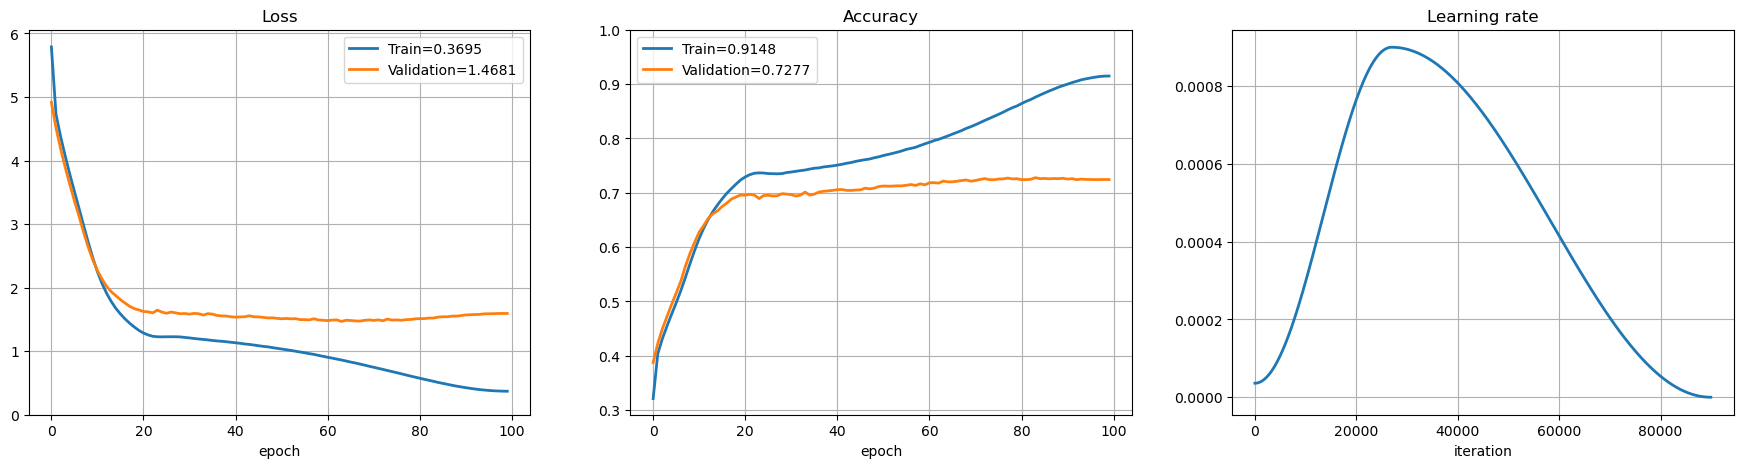

In [60]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

### Exercise (predict implementation)
Complete the `Predict` function implementation.  

Note: A [beam search](https://en.wikipedia.org/wiki/Beam_search) should be used instead of top 1 method.

In [113]:
from torch.distributions.categorical import Categorical

def Predict(oModel, vX, bTop1=False):
    MAX_LENGTH = 16
    vY         = oVocabY['<PAD>'] * torch.ones(MAX_LENGTH, dtype=torch.int32, device=vX.device)
    vY[0]      = oVocabY['<SOS>']
    #-- Encode:
    mH, mMaskX = ???

    for ii in range(1, MAX_LENGTH):
        #-- Decode:
        vZ = ???
        
        if bTop1 == True:
            y = ???
        else:
            y = ???

        vY[ii] = y
        
        if y == ???
            break

    return ???

In [120]:
dLang = pd.DataFrame(index=range(5), columns=['English', 'GT (Hebrew)', 'Generated'])

for ii in range(5):
    idx        = np.random.randint(nTest)
    vEng, vHeb = oTestSet[idx]
    vEng       = vEng.to(DEVICE)
    with torch.no_grad():
        vHebOut = Predict(oModel, vEng, bTop1=True)

    sEng             = Tensor2Line(oEngVocab, vEng[1:-1])
    sHeb             = Tensor2Line(oHebVocab, vHeb[1:-1])
    sHebHat          = Tensor2Line(oHebVocab, vHebOut)
    dLang.iloc[ii,:] = [sEng, sHeb, sHebHat]

dLang

,English,GT (Hebrew),Generated
0,there used to be a bridge here .,בעבר היה כאן גשר .,היה שם גשר פה .
1,i like to sleep on a soft bed .,אני אוהב לישון על מיטה רכה .,אני אוהבת לישון על מיטה רכה .
2,i don t know if she wants to go with me .,אינני יודע אם היא רוצה לבוא איתי .,אני לא יודע אם היא רוצה לבוא איתי .
3,that sounds logical .,זה נשמע הגיוני .,זה נשמע הגיוני .
4,she is a nurse .,היא אחות רפואית .,היא אחות .


In [119]:
line = 'Write here your line!'
line = NormalizeEnglish(line)
vEng = Line2Tensor(oEngVocab, line).to(DEVICE)
with torch.no_grad():
    vHebOut = Predict(oModel, vEng, bTop1=True)
    
sHebPred = Tensor2Line(oHebVocab, vHebOut)    
sHebPred

'כתוב כאן את השורה שלך !'

In [ ]:
# from torch.distributions.categorical import Categorical

# def Predict(oModel, vX, bTop1=False):
#     MAX_LENGTH = 16
#     vY         = oVocabY['<PAD>'] * torch.ones(MAX_LENGTH, dtype=torch.int32, device=vX.device)
#     vY[0]      = oVocabY['<SOS>']
#     #-- Encode:
#     mH, mMaskX = oModel.Encode(vX[None,:])

#     for ii in range(1, MAX_LENGTH):
#         #-- Decode:
#         vZ = oModel.Decoce(mH, mMaskX, vY[None,:ii])[0,:,-1]
        
#         if bTop1 == True:
#             y = vZ.argmax()
#         else:
#             y = Categorical(logits=vZ).sample()

#         vY[ii] = y
        
#         if y == oVocabY['<EOS>']:
#             break

#     return vY[1:ii]